# Calculate ciCOH Values: 

* For both normal and mild LFP data of Bug

* Return phase [reachonset Touch] in single kluverboard task

* [19 21]Hz

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import random
import pandas as pd
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## Preparation

### exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder, correparentfolder = code_corresfolder(os.getcwd(), nb_name)

### Global parameters

In [6]:
freq = [19, 21]

eventphase = 'return'


tdur_min, tdur_max = 0.5, 1
tdur_reach = tdur_min

filesUsed = 'alldays' # 'samedays', or 'closedays' or 'alldays' or 'remaindays'

In [7]:
coli_target, coli_reachonset, coli_touch, coli_returnonset, coli_mouth = 0, 1, 2, 3, 4


if eventphase == 'reach':
    cols = [coli_reachonset, coli_touch]
    
elif eventphase == 'return':
    cols = [coli_returnonset, coli_mouth]

### Input setup

In [8]:
inputfolder = os.path.join(pipelinefolder, 'NHP_Bug', '0_dataPrep', 'SKT', 
                           'm3_STKData_narrowfiltered' + str(freq[0]) + '_' + str(freq[1]))

In [9]:
variablesinLoadfile = ['lfpdata', 'idxevent_Matrix', 'idxevent_vNames', 'fs', 'chnsarea_Cell']

In [10]:
chnInf_folder = correparentfolder

chnInf_file_normal = os.path.join(chnInf_folder, 'Bug_chn_brainArea_simCoord_M1ThaSMADBS_normal.csv')
chnInf_file_mild = os.path.join(chnInf_folder, 'Bug_chn_brainArea_simCoord_M1ThaSMADBS_mild.csv')

### Save setup

In [11]:
savefolder = corresfolder
savefilename =  'ciCOH_STK_' + 'freq_' + str(freq[0]) + '_' + str(freq[1]) + '_' + eventphase 
if filesUsed == 'samedays':
    savefilename = savefilename + '_samedays'
elif filesUsed == 'closedays':
    savefilename = savefilename + '_closedays'
elif filesUsed == 'remaindays':
    savefilename = savefilename + '_remaindays'

## Extract lfp & chnInf 

### Extract lfp

In [12]:
def lfpallfiles_extract(files):
    """
        @Return:
            lfpdata: nchns 
            
    """
    
    if 'lfpdata' in locals():
        del lfpdata
        
        
    for filei, file in enumerate(files):
        matdat = sio.loadmat(file, 
                     variable_names = variablesinLoadfile, 
                     struct_as_record = False, squeeze_me = True)


        # fs: sample rate
        fs = matdat['fs'] 



        ### dealing lfp data

        # lfp: nchns * ntemp * ntrials
        lfp = matdat['lfpdata']


        # idxevent (np.ndarray, ntrials * 5) indices for targetonset, reachonset, reach, return and mouth
        idxevent = matdat['idxevent_Matrix']


        idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))
        idxdur_reach = int(np.round(tdur_reach * fs))

        if len(lfp.shape) == 2: # only has one trial
            lfp = np.expand_dims(lfp, axis = 2)
            idxevent = np.expand_dims(idxevent, axis = 0)

        ntrials = lfp.shape[2]

        # deal each trial in lfp of one file
        for triali in range(ntrials):

            # start and end indices over time of specific phase for triali 
            idxtime_str, idxtime_end = int(idxevent[triali][cols[0]]), int(idxevent[triali][cols[1]])    

            # remove trials of return phase longer than tdur_max and shorter than tdur_min
            if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
                continue;


            # extract lfp data in specific phase of one trial (n_chns * n_times)
            lfp_1trial = np.expand_dims(lfp[:, idxtime_str:idxtime_str + idxdur_reach, triali], axis=2)       


            # append new trial to lfpdata
            if 'lfpdata' not in locals():
                lfpdata = lfp_1trial
            else:
                lfpdata = np.concatenate((lfpdata, lfp_1trial), axis = 2)

            del lfp_1trial, idxtime_str, idxtime_end

        del matdat, fs, idxevent, lfp
        
        
    return lfpdata

In [13]:
if filesUsed == 'samedays':  
    df = pd.read_csv(os.path.join(inputfolder,'FilesSameDaysAsRest.csv'))
    
    df_normal, df_mild = df['normal'].dropna(), df['mild'].dropna()
    
    files_normal = [os.path.join(inputfolder, file) for file in df_normal.values.tolist()]
    files_mild = [os.path.join(inputfolder, file) for file in df_mild.values.tolist()]
            
elif filesUsed == 'closedays':
    df = pd.read_csv(os.path.join(inputfolder,'FilesCloseDaysAsRest.csv'))
    
    df_normal, df_mild = df['normal'].dropna(), df['mild'].dropna()
    
    files_normal = [os.path.join(inputfolder, file) for file in df_normal.values.tolist()]
    files_mild = [os.path.join(inputfolder, file) for file in df_mild.values.tolist()]
    
    
elif filesUsed == 'remaindays':
    df = pd.read_csv(os.path.join(inputfolder,'FilesRemainDays.csv'))
    
    df_normal, df_mild = df['normal'].dropna(), df['mild'].dropna()
    
    files_normal = [os.path.join(inputfolder, file) for file in df_normal.values.tolist()]
    files_mild = [os.path.join(inputfolder, file) for file in df_mild.values.tolist()]
            
else:
    files_normal = glob.glob(os.path.join(inputfolder, '*_normal_*'))
    files_mild = glob.glob(os.path.join(inputfolder, '*_mild_*'))

In [14]:
# lfptrials_normal, lfptrials_mild: nchns * ntemp * ntrials
lfptrials_normal = lfpallfiles_extract(files_normal)
lfptrials_mild = lfpallfiles_extract(files_mild)

In [15]:
print(lfptrials_mild.shape)
print(lfptrials_normal.shape)

(43, 250, 753)
(36, 250, 187)


### Extract chnInf 

In [16]:
### normal : load channel information ###
chnInf_file = chnInf_file_normal


df = pd.read_csv(chnInf_file, header = 0)

# recording chni 
chnInf_recchni = df['recording_chni'].tolist()

chnInf_brainarea = df['brainarea']
chnInf_matchni = df['mat_chni']

# coord
x, y = df['simulated_x'].to_numpy(), df['simulated_y'].to_numpy()
chnInf_coord = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)), axis = 1)


chnInf = dict()
chnInf['chnInf_recchni'], chnInf['chnInf_matchni'] = chnInf_recchni, chnInf_matchni
chnInf['chnInf_brainarea'], chnInf['chnInf_coord'] = chnInf_brainarea, chnInf_coord 


chnInf_normal = chnInf.copy()

del chnInf_file, df, chnInf_recchni, chnInf_brainarea, chnInf_matchni, x, y, chnInf_coord, chnInf

In [17]:
### mild : load channel information ###
chnInf_file = chnInf_file_mild


df = pd.read_csv(chnInf_file, header = 0)

# recording chni 
chnInf_recchni = df['recording_chni'].tolist()

chnInf_brainarea = df['brainarea']
chnInf_matchni = df['mat_chni']

# coord
x, y = df['simulated_x'].to_numpy(), df['simulated_y'].to_numpy()
chnInf_coord = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)), axis = 1)


chnInf = dict()
chnInf['chnInf_recchni'], chnInf['chnInf_matchni'] = chnInf_recchni, chnInf_matchni
chnInf['chnInf_brainarea'], chnInf['chnInf_coord'] = chnInf_brainarea, chnInf_coord 


chnInf_mild = chnInf.copy()

del chnInf_file, df, chnInf_recchni, chnInf_brainarea, chnInf_matchni, x, y, chnInf_coord, chnInf

## Calculate ciCOH

### balance mild and normal trials

In [18]:
# select the smaller trial number
ntrials_normal, ntrials_mild = lfptrials_normal.shape[2], lfptrials_mild.shape[2]
ntrials = min([ntrials_normal, ntrials_mild])

# balance trials
lfptrials_normal = lfptrials_normal[:,:,0:ntrials]
lfptrials_mild = lfptrials_mild[:,:,0:ntrials]

###  normal ciCOH

In [19]:
lfptrials = lfptrials_normal

### calculate ciCOH
nchns = lfptrials.shape[0]
ciCOH = np.zeros((nchns, nchns))

for chni in range(nchns-1):
    
    # signal of channel chni
    signal1 = lfptrials[chni, :, :]
    
    for chnj in range(chni+1, nchns):
        
         # signal of channel chnij
        signal2 = lfptrials[chnj, :, :]
        
        # ciCOH assignment
        ciCOH[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH[chnj, chni] = ciCOH[chni, chnj]

        del signal2
    del signal1
    
ciCOH_normal = ciCOH
del ciCOH, lfptrials, nchns

### mild ciCOH

In [20]:
lfptrials = lfptrials_mild

### calculate ciCOH
nchns = lfptrials.shape[0]
ciCOH = np.zeros((nchns, nchns))

for chni in range(nchns-1):
    
    # signal of channel chni
    signal1 = lfptrials[chni, :, :]
    
    for chnj in range(chni+1, nchns):
        
         # signal of channel chnij
        signal2 = lfptrials[chnj, :, :]
        
        # ciCOH assignment
        ciCOH[chni, chnj] =  np.mean(ciCoherence_acrosstrials(signal1, signal2))

        # symmetrical
        ciCOH[chnj, chni] = ciCOH[chni, chnj]

        del signal2
    del signal1
    
ciCOH_mild = ciCOH
del ciCOH, lfptrials, nchns

## save

In [21]:
ciCOH = dict()
ciCOH['normal'], ciCOH['mild'] = ciCOH_normal, ciCOH_mild
ciCOH['chnInf_normal'], ciCOH['chnInf_mild'] = chnInf_normal, chnInf_mild 

In [22]:
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

with open(os.path.join(savefolder, savefilename + '.pickle'), 'wb') as fp:
    pickle.dump(ciCOH, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
os.path.join(savefolder, savefilename + '.pickle')

'/Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Bug/1_dataAnaly/FCAnaly/SKT/m1_SKT_calcciCOH_Fre19-21Hz_return/ciCOH_STK_freq_19_21_return.pickle'

## plot section

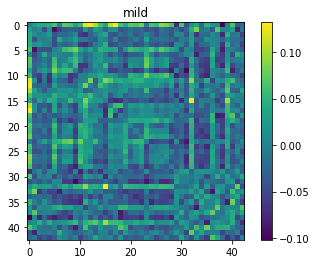

In [24]:
plt.imshow(ciCOH['mild']);
plt.colorbar()
plt.title('mild')
plt.show()

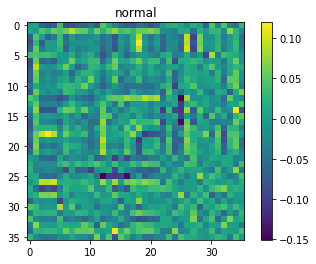

In [25]:
plt.imshow(ciCOH['normal'])
plt.title('normal')
plt.colorbar()
plt.show()